# Image Processing: Histogram of Oriented Gradients (HOG) with MNIST Dataset

In [35]:
import torch
import torch.nn as nn
from torchvision.datasets import MNIST
from torch.utils.data import DataLoader
from sklearn.preprocessing import OneHotEncoder
from skimage.feature import hog
from sklearn.metrics import accuracy_score, confusion_matrix
import matplotlib.pyplot as plt
import numpy as np
import itertools

In [36]:
def apply_hog(img, o = 9, ppc = (8, 8), cpb = (2, 2)):
    # apply HOG to image
    features = hog(
        img,
        orientations = o,
        pixels_per_cell = ppc,
        cells_per_block = cpb,
    )

    return features

In [2]:
# set GPU
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cuda:0


The `MNIST` class loads in the data.
- Train set size: 60000
- Test set size: 10000

All images have size $28\times 28$ pixels.

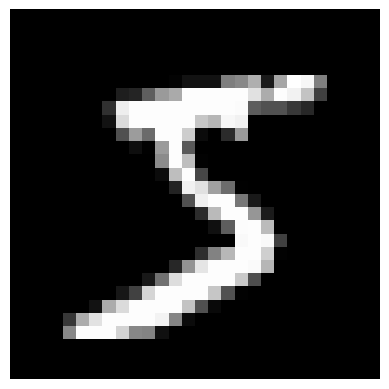

Image Shape: torch.Size([28, 28])
Target: tensor(5)

Train Set (Image): torch.Size([60000, 28, 28])
Train Set (Target): torch.Size([60000])

Test Set (Image): torch.Size([10000, 28, 28])
Test Set (Target): torch.Size([10000])


In [17]:
# load datasets
mnist_train = MNIST("./data/", download = True)
mnist_test = MNIST("./data/", train = False, download = True)

# sample = first image
sample_image = mnist_train.data[0, :, :]
sample_target = mnist_train.targets[0]

# show image
plt.imshow(sample_image, cmap = "gray")
plt.axis("off")
plt.show()

print("Image Shape:", sample_image.shape)
print("Target:", sample_target)
print()
print("Train Set (Image):", mnist_train.data.shape)
print("Train Set (Target):", mnist_train.targets.shape)
print()
print("Test Set (Image):", mnist_test.data.shape)
print("Test Set (Target):", mnist_test.targets.shape)

In [16]:
mnist_train.targets

tensor([5, 0, 4,  ..., 5, 6, 8])

In [21]:
targets = mnist_train.targets
print(targets)
print(targets.shape)
print(targets.reshape(1, -1))

tensor([5, 0, 4,  ..., 5, 6, 8])
torch.Size([60000])
tensor([[5, 0, 4,  ..., 5, 6, 8]])


Apply `OneHotEncoder` to the targets. Each label will be expanded to 10 dimensions.
- `reshape(-1, 1)`: changes the dimensions of the target into a $N\times 1$ vector
- `reshape(1, -1)`: changes the dimensions of the target into a $1\times N$ vector (**not what we want**)

In [34]:
# initialize one hot encoder for targets
enc = OneHotEncoder(sparse = False)
targets = enc.fit_transform(mnist_train.targets.reshape(-1, 1))
print("TARGETS:\n", targets)
print(targets.shape)

TARGETS:
 [[0. 0. 0. ... 0. 0. 0.]
 [1. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 1. 0.]]
(60000, 10)


The HOG function with the following parameters outputs a 1D feature array of size 144.
- `orientations = 9`
- `pixels_per_cell = (8, 8)`
- `cells_per_block = (2, 2)`

In [45]:
# apply HOG to sample image
sample_features = apply_hog(sample_image)
print(sample_features.shape)

(144,)


In [46]:
# define SVM model
INPUT_FEATURES = sample_features.shape[0]
OUTPUT_CLASSES = 10

model = nn.Linear(144, 10).to(device)
criterion = nn.MultiLabelMarginLoss()
optimizer = torch.optim.SGD(model.parameters(), lr = 0.01)

In [47]:
# initialize data loader
BATCH_SIZE = 128
train_loader = DataLoader(mnist_train, batch_size = BATCH_SIZE, shuffle = True)
test_loader = DataLoader(mnist_test, batch_size = BATCH_SIZE, shuffle = False)

In [48]:
# train model
losses = []
num_epochs = 2
for it in range(num_epochs):
    for images, labels in train_loader:
        print(images.shape, labels.shape)

TypeError: default_collate: batch must contain tensors, numpy arrays, numbers, dicts or lists; found <class 'PIL.Image.Image'>